# Breweries, Beer, and Breviews: Unraveling the Global Beer Preferences
## Introduction
### Abstract
Our project explores the dynamic relationship between brewery prevalence, beer consumption, and customer reviews to better understand global user preferences and their evolution over time. We aim to uncover what people enjoy drinking and how their preferences change across time and regions. <br>
To achieve this, we will utilize RateBeer, a popular beer ratings platform, combining quantitative methods—such as correlation, regression, and natural language processing (NLP)—with qualitative tools like pie charts, bar plots, and maps. This approach will help us analyze how characteristics like beer styles and alcohol content influence a beer's popularity. <br>
Our analysis extends beyond global trends, focusing on how preferences evolve over time and vary between countries. Ultimately, we seek to identify potential trend, either global or local, in the beer-loving community and explore if the beer culture of a country influences its beer preferences.

### Research questions
Our study addresses the following key questions:
1. Which specific beer characteristics (e.g., alcohol content, style, and other features) are most favored by users, and how do they influence a beer's overall rating?
2. How do these influential characteristics vary across countries and over time?
3. Are people more inclined to prefer beers from their own country, or do they embrace international options?


## Repository structure
The structure of the repository is as follows: <br><br>
<code>
|
|── analysis/             # Analysis notebooks
|   ├── NLP_preprocessing.ipynb  # Data storing and pre-preprocessing. Mostly lemmatization, stopwords removal and embeddings generation. Stores all generated data in PQ & npy format.
|   ├── NLP_analysis.ipynb   # NLP analysis for website data. Requires all data to be already stored in PQ format. 
├── data/  
│   ├── processed/        # Processed data stored here  
│   └── raw/              # Place the RateBeer dataset here  
├── docs/                 # Datastory code for GitHub Pages  
│   ├── img/              # Images for the datastory  
│   ├── plots/            # Plots used in the datastory, categorized by sections  
│   └── src/              # Additional JS and CSS files for the datastory  
├── src/                  # Analysis code  
│   ├── data/             # Code for data processing  
│   ├── processing/       # Code used in the results notebook  
│   └── utils/            # Utility functions for analysis  
</code> <br>
The installation guide is provided in the `README.md` file in the root directory.

## Notes about this notebook
In most of the analysis interactive plots are needed to avoid a too cluttered visualization and we have used for this purpose the `plotly` library. <br>
Since we know that in some cases there might be issue in visualizing them if you have any of these problems we have put a link under each plot that will redirect you to a browser interface where you can see the plot.

## Include Libraries and initial settings
### Import all the libraries

In [1]:
# Import all the libraries
import pandas as pd

# Shutdown FutureWarning and UserWarning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

# Define the folder
FOLDER = 'data/processed/'
SAVING_FOLDER = 'docs/plots/'

### Load and filter the data
#### Load the data

In [2]:
df_beers = pd.read_parquet(FOLDER + 'beers.pq')
df_breweries = pd.read_parquet(FOLDER + 'breweries.pq')
df_users = pd.read_parquet(FOLDER + 'users.pq')
df_ratings_no_text = pd.read_parquet(FOLDER + 'ratings_no_text.pq')

## Data presentation
Here we are going to have an overview of the dataset, which has been carefully cleaned and is nearly ready for analysis. We will summarize the data, display the first few rows, and describe the data types of the columns. For columns that are not self-explanatory, a brief description is included. <br><br>
Let's start by looking at the beer dataset.

In [3]:
df_beers.head(5)

,beer_id,beer_name,brewery_id,brewery_name,style,abv
3,155699,Ards Bally Black Stout,13538,Ards Brewing Co.,Stout,4.6
4,239097,Ards Belfast 366,13538,Ards Brewing Co.,Golden Ale/Blond Ale,4.2
5,380930,Ards Bittles Christmas,13538,Ards Brewing Co.,Bitter,4.2
6,234108,Ards Bittles Citra Autumn Ale,13538,Ards Brewing Co.,American Pale Ale,5.1
7,396830,Ards Cardy Man,13538,Ards Brewing Co.,Stout,4.2


In [4]:
format_numeric_values = lambda x: f"{x:,.0f}"
print(f"In the platform there are {format_numeric_values(df_beers.shape[0])} different beers")

In the platform there are 314,204 different beers


Let's continue by looking at the brewery dataset.

In [5]:
df_breweries.head(5)

,brewery_id,brewery_name,country_brewery,state_brewery
1,13538,Ards Brewing Co.,United Kingdom,None
2,22304,Barrahooley Craft Brewery,United Kingdom,None
3,22818,Boundary,United Kingdom,None
4,24297,Brewbot Belfast,United Kingdom,None
5,27006,Bullhouse Brewing Company,United Kingdom,None


We have chosen, to ease the analysis processes, to split the location into two columns:
- One for the country.
- A separate column for US states.

This split was specifically applied to the US because it has a significant amount of data and combining all states into a single "US" entity would have obscured important insights in some analysis. Additionally, the size and population of many US states are comparable to those of entire countries. This approach was not extended to other countries due to the lack of state-level data for them. The split allows also to consider the US as an unique entity when we want a more "overview" analysis.<br><br>
The same choice has been made for all the location columns.

In [6]:
print(f"In the platform there are {format_numeric_values(df_breweries.shape[0])} different breweries")

In the platform there are 19,668 different breweries


Let's now add the location columns to the beers dataset

In [7]:
df_beers = df_beers.join(df_breweries[['brewery_id', 'country_brewery', 'state_brewery']].set_index('brewery_id'), on='brewery_id').rename(columns={'country_brewery': 'country_beer', 'state_brewery': 'state_beer'})
df_beers.head(5)

,beer_id,beer_name,brewery_id,brewery_name,style,abv,country_beer,state_beer
3,155699,Ards Bally Black Stout,13538,Ards Brewing Co.,Stout,4.6,United Kingdom,None
4,239097,Ards Belfast 366,13538,Ards Brewing Co.,Golden Ale/Blond Ale,4.2,United Kingdom,None
5,380930,Ards Bittles Christmas,13538,Ards Brewing Co.,Bitter,4.2,United Kingdom,None
6,234108,Ards Bittles Citra Autumn Ale,13538,Ards Brewing Co.,American Pale Ale,5.1,United Kingdom,None
7,396830,Ards Cardy Man,13538,Ards Brewing Co.,Stout,4.2,United Kingdom,None


Now we can go on and look at the user dataset.

In [8]:
df_users.head(5)

,user_id,user_name,joined,country_user,state_user
0,175852,Manslow,2012-05-20 10:00:00,Poland,None
2,288889,Sibarh,2013-11-16 11:00:00,Poland,None
3,250510,fombe89,2013-03-22 11:00:00,Spain,None
4,122778,kevnic2008,2011-02-02 11:00:00,Germany,None
5,227834,Beerhunter111,2012-11-12 11:00:00,Germany,None


In [9]:
print(f"In the platform there are {format_numeric_values(df_users.shape[0])} different users")

In the platform there are 46,974 different users


And finally let's have a look at the ratings dataset.

In [10]:
df_ratings_no_text.head(5)

,date,beer_id,user_id,brewery_id,abv,style,rating,mouthfeel,taste,appearance,aroma,overall,year,brewery_name,country_brewery,state_brewery,country_user,state_user
38,2015-04-16 12:00:00,155699,151109,13538,4.6,Stout,3.7,2.0,8.0,3.0,7.0,17.0,2015,Ards Brewing Co.,United Kingdom,None,Ireland,None
41,2013-10-01 12:00:00,155699,224156,13538,4.6,Stout,4.0,3.0,5.0,5.0,8.0,19.0,2013,Ards Brewing Co.,United Kingdom,None,United Kingdom,None
42,2013-06-18 12:00:00,155699,88501,13538,4.6,Stout,3.6,4.0,7.0,4.0,7.0,14.0,2013,Ards Brewing Co.,United Kingdom,None,New Zealand,None
43,2011-11-17 12:00:00,155699,128086,13538,4.6,Stout,4.0,5.0,7.0,5.0,7.0,16.0,2011,Ards Brewing Co.,United Kingdom,None,United Kingdom,None
44,2013-11-23 12:00:00,239097,128086,13538,4.2,Golden Ale/Blond Ale,3.0,3.0,5.0,4.0,6.0,12.0,2013,Ards Brewing Co.,United Kingdom,None,United Kingdom,None


The ratings comes from the [RateBeer](ratebeer.com) website which has the following rating system (source [RateBeer Scores](https://www.ratebeer.com/our-scores)):
- <b>Aroma</b>: The smell of the beer
- <b>Appearance</b>: The color, clarity, head and visual carbonation of this beer.
- <b>Taste</b>: The flavors in this beer, thinking about the palate, bitterness and finish.
- <b>Mouthfeel</b>: The body of the beer, carbonation and astringency.
- <b>Overall</b>: The overall characteristics and your personal experience of the beer.

Appearance and Mouthfeel are each scored out of 5. Aroma and Taste are scored out of 10. While Overall is scored out of 20. These all combine to give the beer a total score out of 50 (the <b>Rating</b> column), which is then divided and displayed as a score out of 5. <br>
In the following we are going to use either the overall or the rating column to refer to the score of the beer. The choice will be made based on the analysis to be done and the attribute that best fits the analysis. We'll consider them as an overall impression of the beer (given that it's the rate of the personal experience of the beer) even if when we want to summarize all the different aspects we'll use the rating since it is the sum of all the other scores.
<br><br>
The country of the brewery is computed from the <code>brewery</code> dataset while the country of the user is computed from the <code>user</code> dataset.

In [11]:
print(f"In the platform there are {format_numeric_values(df_ratings_no_text.shape[0])} different ratings")
print(f"The first rating was made on {df_ratings_no_text['date'].min()}")
print(f"The last rating was made on {df_ratings_no_text['date'].max()}")

In the platform there are 6,417,388 different ratings
The first rating was made on 2002-01-01 12:00:00
The last rating was made on 2016-12-31 12:00:00


We see that our dataset ends and begin at the beginning of January 2002 and ends at the end of December 2016 with a total of 6,424,384 different ratings. Some of the ratings have been removed to ensure consistent results. <br>
We indeed observed that by considering earlier and later ratings the results for those years were not consistent or reasonable mainly because:
- The first year that where we have data from the beginning of January is 2001 but by looking at the other data it seemed that the data was not consistent with the other years. We have excluded this year.
- The last year that ends at the end of December is 2016 because for 2017 we don't have data for the second half of the year. The number of ratings this year indeed are completely off if compared with the other years.

Now that we had an overview of the data let's have a look at the geographical distribution of our data in the world.

In [12]:
# Include all the coee needed for the data presentation
from src.processing import presentation as pr
data_presentation = pr.DataPresentation(df_beers, df_breweries, df_users, df_ratings_no_text, f'{SAVING_FOLDER}/data_presentation/')

In [13]:
# Plot the aggregated spatial data
data_presentation.plot_spatial_data()

If you can't see the above plot you can find it also [here](https://epfl-ada.github.io/ada-2024-project-sadamasochists/notebook_fallback/spatial_data.html)

In [14]:
# Plot the top 5 for each category
data_presentation.plot_top_5()

If you can't see the above plot you can find it also [here](https://epfl-ada.github.io/ada-2024-project-sadamasochists/notebook_fallback/top_5_countries.html)

We see that most of the data are concentrated in the United States, Canada and European countries. The most active state in the United States is California. <br>
We see that while we have data for South America, Asia and Oceania other than Austrialia in the other countries the quantity of data is quite low, probably due to the fact the website is US based. <br><br>
From this we can see that the dataset is slightly biased towards Europe and United States even if it's quite representative of the world.

Finally let's review the temporal distribution of the data.

In [15]:
# Plot the number of ratings over time
data_presentation.plot_number_of_ratings_over_time()

If you can't see the above plot you can find it also [here](https://epfl-ada.github.io/ada-2024-project-sadamasochists/notebook_fallback/number_of_ratings_over_time.html)

In [16]:
# Plot the number of users that have joined the platform over time
data_presentation.plot_number_of_users_over_time()

If you can't see the above plot you can find it also [here](https://epfl-ada.github.io/ada-2024-project-sadamasochists/notebook_fallback/number_of_new_users_over_time.html)

We see that the number of ratings peak in 2015 while the number of new users peak in 2012 with a decline after that year.

## Global analysis
After studing which data are available, how they are distributed geographically and temporally we can start to analyze them. Here we are going to study popularity generally, without focusing on specific factors (as we'll do later in the next sections).
### General study of the distribution of the ratings
First of all we are going to study how the grades are distributed in the different categories.

In [17]:
# Include all the code needed for the global ratings analysis
from src.processing import global_analysis as gp
global_analysis = gp.GlobalAnalysis(df_beers, df_breweries, df_users, df_ratings_no_text, SAVING_FOLDER + 'global_analysis/')

In [18]:
# Display the ratings distribution
global_analysis.display_ratings_distribution()

If you can't see the above plot you can find it also [here](https://epfl-ada.github.io/ada-2024-project-sadamasochists/notebook_fallback/ratings_distribution.html)

Before doing any conclusion also let's compute some key metrics for each category.

In [19]:
# Plot the different statistics of the ratings distribution
global_analysis.display_ratings_statistics()

Statistics of the ratings 
 
 
 Rating 
 Mean 
 Std 
 Median 
 Skewness 
 Kurtosis 
 Can reject H0 (95%) 
 
 
 
 
 mouthfeel 
 3.27 
 0.79 
 3.0 
 -0.19 
 0.25 
 True 
 
 
 taste 
 6.48 
 1.53 
 7.0 
 -0.79 
 1.01 
 True 
 
 
 appearance 
 3.43 
 0.77 
 3.0 
 -0.15 
 0.26 
 True 
 
 
 aroma 
 6.4 
 1.53 
 7.0 
 -0.77 
 1.0 
 True 
 
 
 overall 
 13.18 
 3.14 
 14.0 
 -0.99 
 1.4 
 True 
 
 
 rating 
 3.28 
 0.68 
 3.4 
 -0.92 
 1.42 
 True

We observe multiple interesting aspects:
- **Central Tendency Bias:**  All the ratings have a mean and median close to the center of the rating scale. This suggests users exhibit a central tendency bias, where they avoid extreme judgments and rate attributes near the middle of the scale.
- **Non normaly of the distribution:** The distribution of the ratings is not normal, with a skewness that is always different from 0. This hypothesis is confirmed by the Shapiro-Wilk test that rejects the null hypothesis of normality for all the categories with a good confidence level.
- **Category-specific Observations:**  While the mean and median are generally close to the center of the rating scale, there are notable differences, both numerically and visually:  

  - **Mouthfeel and Appearance:**  
    - The mean is slightly higher than the median, and skewness is lower compared to other categories.  
    - This suggests users are more demanding in these categories, leading to generally lower ratings.  
    - The subjectivity and difficulty in evaluating these attributes could also play a role. For instance, what constitutes a "5-star" mouthfeel is often ambiguous.  

  - **Taste and Aroma:**  
    - The median is slightly higher than the mean, indicating users favor these categories and tend to give them higher ratings.  
    - This suggests users genuinely enjoy these aspects, resulting in more favorable evaluations.  

  - **Overall Rating:**  
    - The overall score leans toward the higher end of the scale, potentially influenced by taste and aroma ratings. This phenomenon is called **halo effect**, where a positive impression in one area influences the overall judgment even if other aspects are less favorable.

- **Possible presence of a social bias:** The fact that you usually drink beers in social and convivial contexts could lead to a social bias in the ratings that could push the ratings towards the higher values. An "average" beer could be rated higher than it might be because the user was in a good mood or in a good company, which made the user enjoy the beer more than it would have been in a different context.

From these results we can state that the users are generally more demanding in the categories of Mouthfeel and Appearance while they in general like more the Aroma and the Taste which seems to positively influence the Overall rating. We are going to check this final observation in the next section.

### Correlation between the ratings attributes
Here we are going to use the overall rating rather than the rating itself due to the fact that the rating is computed from the other attributes. This would make the study of the correlation between the attributes and the overall rating less interesting since we already know that the rating is a linear combination of the other attributes. <br>

In [20]:
# Display the correlation matrix
global_analysis.plot_correlation_matrix()

If you can't see the above plot you can find it also [here](https://epfl-ada.github.io/ada-2024-project-sadamasochists/notebook_fallback/correlation.html)

We see that taste and aroma show the highest correlations with overall beer ratings, at <b>0.86</b> and <b>0.77</b>, respectively. These attributes dominate the beer experience given their impact on the overall flavor profile.

Appearance and palate, on the other hand, have moderate correlations with overall beer ratings, at <b>0.50</b> and <b>0.66</b>, respectively. The lower correlation, compared with the one of taste and aroma, suggests that these attributes play a secondary role in the overall experience, either for the complexity of the evaluation or for the less preference of the users for these attributes.

Alcohol by volume (ABV) has the lowest correlation overall (with a correlation of <b>0.37</b> with the overall ratings). This value, even if it's the smallest, it's still significant given that we would have expected a significant lower value. This suggests that there is some link between the ABV and the users preferences that we are going to explore further in the next sections.

We see that there is a strong relation between the different parameters and the overall score. Can we use them to predict wether or not the user will enjoy the beer?

In [21]:
results, r_squared, rmse = global_analysis.regression_analysis(df_ratings_no_text)
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                overall   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                 4.371e+06
Date:                Fri, 20 Dec 2024   Prob (F-statistic):               0.00
Time:                        19:43:11   Log-Likelihood:            -9.3464e+06
No. Observations:             5135052   AIC:                         1.869e+07
Df Residuals:                 5135047   BIC:                         1.869e+07
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.1787      0.001      2e+04      0.0

In [22]:
print(f"The R-squared value at test is {r_squared:.4f}")
print(f"The RMSE value at test is {rmse:.2f}")

The R-squared value at test is 0.7730
The RMSE value at test is 1.50


It seems we can do this!</br><br>
From the linear regression model we can clearly see that the four parameters are significant in predicting the overall experience of an user and whether or not one will like the beer. We see that approximately 77% of the variance is explained by the model with a test set and that the RMSE is quite low, approximately <b>1.50</b>, which is not significant in a scale with a granularity of </b>1</b>. <br>
From the p value we see that all the parameters are significant in the prediction of the overall grade (the p value for all of them is almost zero). <br>
We see that taste has almost double the impact on the overall experience than aroma, with the first one that has a coefficient of <b>1.7843</b> vs a coefficient of <b>0.7184</b> for the second parameter. We see that the appearance and the mouthfeel have a much lower impact than the others (respectively <b>0.4159</b> and <b>0.1296</b>). <br><br>
From these results we have a significant insight: if user does't like the taste of a beer than they'll likely won't like the beer at all (Also called <i>halo effect</i>).

### Rating in the different countries
Here we are going to see which are the favourite beer locations in the world. We are going to consider the rating here to have a metric that summarize all the other parameters. For the location we are going to consider the beer location (obtained by the brewery location) since here we want to understand which countries produce the most appreciated beers. <br>

In [23]:
# Display the ratings in the world map
average_rating_no_US, average_rating_US = global_analysis.ratings_world_map()

If you can't see the above plot you can find it also [here](https://epfl-ada.github.io/ada-2024-project-sadamasochists/notebook_fallback/world_ratings.html)

In [24]:
average_rating = pd.concat([average_rating_no_US, average_rating_US]).sort_values('count', ascending=False)
average_rating.head(10)

,location,count
1,Alaska,3.629250
35,Oklahoma,3.618751
4,California,3.601835
34,Ohio,3.551834
12,Illinois,3.546701
36,Oregon,3.532165
47,Washington DC,3.512860
8,Belgium,3.498862
28,New Hampshire,3.489269
9,Georgia,3.488274


In [25]:
average_rating = pd.concat([average_rating_no_US, average_rating_US]).sort_values('count', ascending=True)
average_rating.head(10)

,location,count
81,Nicaragua,1.787751
41,Guatemala,1.819794
29,El Salvador,1.826611
22,Cuba,1.908790
28,Egypt,1.914205
113,Venezuela,1.922243
109,Uganda,1.930599
76,Myanmar,1.955705
26,Dominican Republic,1.980939
104,Tanzania,1.986713


It seems that users tend to favour beers that are produced in the United States. Indeed we see that the top 5 countries in terms of average ratings are all from US and we need to get to the 8th place to find a country outside the states. <br>
We see that the beers produced in European countries are for most slightly above the middle of the scale, with Belgium that is the highest rated country of Europe followed by Norway and Englang. Surprisingly we see that Germany beers are liked slightly less the other Center Europe countries. <br><br>
We see that beers produced outside of Europe are less liked than European or US ones with an average rating significantly low in some countries. The worst ones have an average rating that is below 2.

### Rating evolution over time in the different countries
Here we are going to plot only the countries that have at least one review per year.

In [26]:
# Plot the rating evolution over time
global_analysis.ratings_evolution_map()

If you can't see the above plot you can find it also [here]()

In [27]:
# Plot the mean and median evolution of the different ratings over time
global_analysis.plot_median_mean_ratings_evolution()

If you can't see the above plot you can find it also [here](https://epfl-ada.github.io/ada-2024-project-sadamasochists/notebook_fallback/mean_median_over_time.html)

We see that the ratings over time, with the increase of size of the platform popularity, tends to increase for most countries. <br><br>
We see that in all European countries and in both US and Canada there is an increase in the average rating over time and we see that there is a significant increase of the ratings for overall, aroma and taste which, given the importance of them in the computation of the rating, leads to an increase of the ratings. <br><br>
We can do other observations:
- The overall, aroma and taste have not only an increase in the mean but they also tend to become more biased towards higher values (there is an increase of the median value over the years). This means that over the time people are preferring more and more the aroma and the taste of the beers.
- The appearance and mouthfeel are quite stable both in terms of mean and median with just a slight increase in the mean value for both of them.

## ABV and style analysis
#### ABV analysis
As seen before, the ABV had a surprisingly high correlation with the overall rating. To see if there are some relation with the ABV and the rating we are going to study the ABV avolution over time and the relation between the ABV and the rating. In this section we are going to plot all the plots and then discuss about the results at the end of the section given the highly linked nature of the plots. <br><br>
For the location we are going to use the user location rather than the beer location given that we want to see how the preferences of the users in terms of ABV have changed over time.

In [28]:
# Import all the code needed to plot ABV related content
from src.processing import abv as abv
abv_pres = abv.ABV(df_beers, df_breweries, df_users, df_ratings_no_text, save_folder=SAVING_FOLDER + '/abv')

Here we have done the following:
- We have grouped together all the ratings of a beer with an ABV included in a specific range (we have chosen a granularity of 0.10).
- We have computed the average rating for all the beers in the same range.
- We have counted the number of ratings for that specific range.

The results is a 3D bubble plot where the x axis is the ABV, the y axis is the average rating for the range and the size of the bubble is the number of ratings for that range. <br>

In [29]:
# Plot the ABV Vs Ratings plot
beer_ratings = abv_pres.plot_abv_vs_ratings()

If you can't see the above plot you can find it also [here](https://epfl-ada.github.io/ada-2024-project-sadamasochists/notebook_fallback/abv_ratings.html)

In [30]:
# Plot the correlation between ABV and average rating
abv_pres.plot_corr_abv_ratings(beer_ratings)

If you can't see the above plot you can find it also [here](https://epfl-ada.github.io/ada-2024-project-sadamasochists/notebook_fallback/corr_abv_ratings.html)

In [31]:
# Plot the average ABV over time
abv_pres.plot_abv_evolution()

If you can't see the above plot you can find it also [here](https://epfl-ada.github.io/ada-2024-project-sadamasochists/notebook_fallback/abv_evolution.html)

In the following plot we are going to consider only some of the countries studied so far. This is due to the fact that:
- We are going to consider only countries that have at least one rating per year (to avoid to see them comparing and then disappearing from the plot over the years). For this reason countries that have a significant number of reviews might be missing if they don't satisfy this condition.
- A significant number of reviews (approximately 160 thousand reviews) doesn't have any information regarding the ABV. This might cause that some countries have the minimum number of reviews needed to be considered in the analysis but not enough reviews with the ABV information. We have chosen to keep these reviews even if they didn't have this information to have more data for the other analysis. Additionally the most significant countries (european ones and US) are not affected by this issue.

In [32]:
abv_pres.plot_abv_evolution_map()

If you can't see the above plot you can find it also [here](https://epfl-ada.github.io/ada-2024-project-sadamasochists/notebook_fallback/abv_evolution_map.html)

From the plot we can do multiple considerations:
- The beers with an higher ABV have in general an higher average rating while the ones with a lower ABV have in general a lower average rating. This is confirmed by the quite high correlation between the ABV and the average rating for that ABV. We see also that this correlation is quite stable over the years.
- Over the years we can see an increase in the ratings (as discussed also in the previous section) but we can also see an increase in the average ABV over time. We observe a significant increase in the preferred ABV in all countries even if in some countries, such as Germany or UK, the increase is less important than in other countries.


## Style analysis

In this section we are going to study the preference for the different beers styles. We'll also explain some of the results obtained in the previous sections thanks to the analysis of the styles.

In [33]:
from src.processing.style import StyleAnalysis
style_pres = StyleAnalysis(df_beers, df_breweries, df_users, df_ratings_no_text, save_folder=SAVING_FOLDER + '/style')

In [34]:
style_pres.plot_pie_chart()

If you can't see the above plot you can find it also [here](https://epfl-ada.github.io/ada-2024-project-sadamasochists/notebook_fallback/styles_pie_chart.html)

We see that approximately <b>25%</b> of the beer market is dominated by only 6 beer styles with the India Pale Ale (IPA) that is the favourite one. We see that a significant amount of beers are from minor or local styles with approximately <b>41.8 %</b> that are from a style that have less than <b>1.90 %</b> of the market. <br>

Hop-driven beers like IPAs dominate many craft beer markets, reflecting a strong preference for bold, aromatic, and versatile flavors. Meanwhile, Belgian Strong Ales and Belgian Ales emphasize the appeal of complex profiles. The popularity of these styles is likely due to their rich history, diverse flavor profiles, and unique brewing techniques. <br>

In the top style we see that there are both easy-drinking beers such as Pale Lagers and Golden Ales but also higher-intensity styles such as Imperial Stouds and Imperial IPA which target consumers seeking robust flavors and higher alcohol content. <br>

Overall we can see that the IPAs emerge as a favourite due to their strong presence in the beer scene even if there is not a single style that significantly dominates the market. 

If we now move from the global to the local point of view we see very interesting results. In the following we are plotting the most consumed beer for each country.

In [35]:
style_pres.plot_favourite_beer_style_country()

If you can't see the above plot you can find it also [here](https://epfl-ada.github.io/ada-2024-project-sadamasochists/notebook_fallback/favourite_beer_style_country.html)

We can see that:
- India Pale Ale (IPA) and Pale Lager are the styles that are the most consumed ones in most of the countries. We see that India Pale Ale (IPA) is the most consumed beer in <b>28</b> countries whereas Pale Lager is the most consumed one in <b>33</b> countries.
- Some very traditional beer countries have very specific preferences:
    - In Germany the most consumed beer style is Pilsner which is a very traditional beer style inthe country.
    - In United Kingdom we have the Bitter style.
    - In Belgium we have the Belgian Ale.
    - In Czech Republic we have the Czech Pilsner.
    
    All these styles are very traditional in these countries and this is reflected in the preferences of the users.

Now we are going to plot the evolution of the style preferences over the years. To do so we are going to use a 3D barplot where:
- The x axis represent the top 10 styles per each year in terms of number of ratings. The most rated ones are to the left.
- The y axis represent the number of ratings for that style.
- The bars are colored based on their average ABV.

We are using a "third dimension" (the color of the bars) to see if a change in style preferences can explain the increase of the ABV over the years observed in the previous section. <br>

In [36]:
style_pres.plot_abv_style_evolution()

If you can't see the above plot you can find it also [here](https://epfl-ada.github.io/ada-2024-project-sadamasochists/notebook_fallback/abv_style_evolution.html)

We see that over the years the style preferences have changed quite a lot. We see that the India Pale Ale (IPA) has become the most consumed style just after 2008 and that another really popular beer style, the Imperial Stout, enters in the top 3 only in 2010. We see a clear decline of the Pale Lager over the years, passing from first position in 2002 to exit from the top 10 in 2016. <br><br>
Thanks to the color of the bars we can see that the most liked styles over the years have a significantly higher average ABV compared to the previous years. For example we can see that while in 2002 the top 3 most liked beer styles had an average abv of respectively <b>4.75</b>, <b>8.80</b> and <b>5.18</b> in 2016 the top 3 most liked beer styles had an average abv of respectively <b>6.52</b>, <b>10.58</b> and <b>5.26</b>, a significant increase.

We have also plotted race between the different styles that can be seen [here](https://epfl-ada.github.io/ada-2024-project-sadamasochists/plots/style/race_video.mp4).

In [37]:
style_pres.plot_style_race()

## Influence of location on beer preference

For many beer consumers it might make sense to look at where the beer is produced before having it. Some countries are known for their large beer cultures and might generally make better beer than others. To investigate this, we will first check for 'beer hubs', countries that are particularly known by others for having good beer. 

We will do this by creating a graph. Each country will have an outgoing edge to another country. The edge will be present only if the other country produces the foreign beer that is most reviewed in the other country. 

In other words, A->B only exists if B produces the most reviewed beer for A with the side constraint that A != B.

To identify hubs numerically, we can print the in-degrees of each country:

In [38]:
from src.processing.location_influence import LocationInfluence
nwp = LocationInfluence(df_ratings_no_text, SAVING_FOLDER + 'location_influence')
nwp.print_in_degrees()

If you can't see the above plot you can find it also [here](https://epfl-ada.github.io/ada-2024-project-sadamasochists/notebook_fallback/in_degrees_map.html)

Now we can see that the USA, Belgium, UK and Germany are large hubs. These are indeed the countries we expect to see, as these have very large beer cultures and are very well-known all over the world. 

But it is also important to check whether all countries like local or foreign beers equally. Even though some countries might drink a lot of foreign beer, they may still have a preference for locally produced products. To investigate this, we can plot the top 10 countries that prefer foreign beers the most, and top 10 countries that like local beers the most. This plot looks as follows:

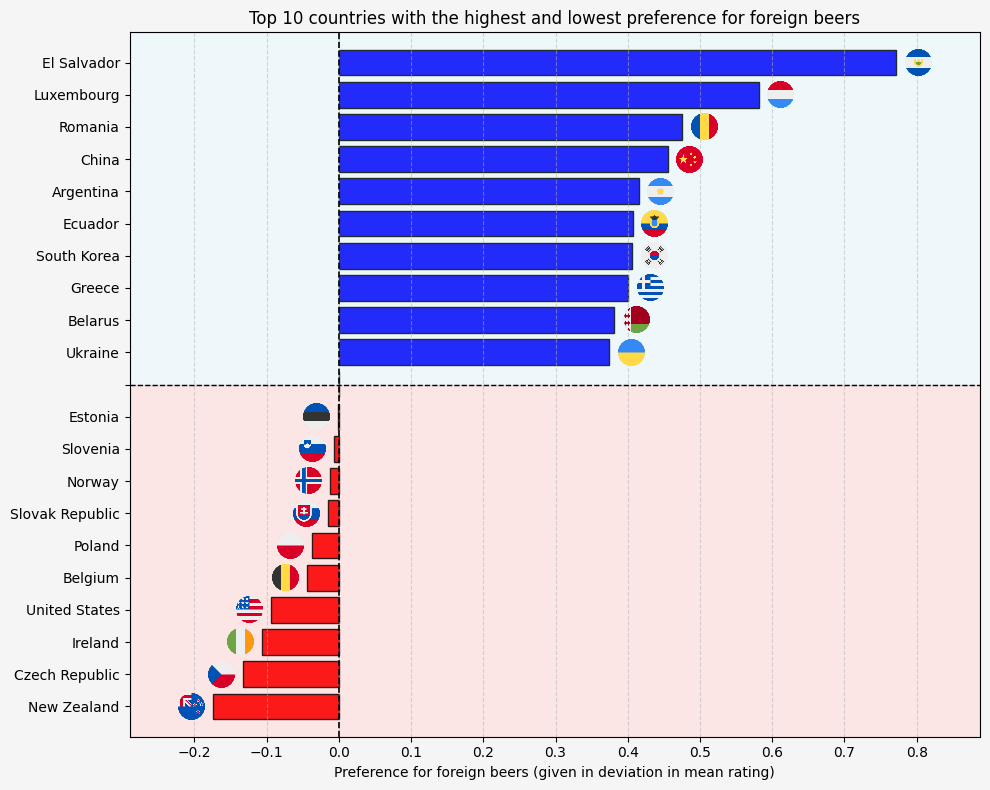

In [39]:
from src.processing.location_influence import MostLeastPlot
mlp = MostLeastPlot(df_ratings_no_text, SAVING_FOLDER + 'location_influence')
mlp.plot()

Here we see very logical results once again. Some countries that are very well-known for their beers have a large preference for local beers. These countries include Czechia, Ireland, the USA and Belgium. On the other side of the spectrum, we have countries that are not known for their beers but are very close to large hubs. El Salvador is quite close to the USA, Luxemberg is very close to Germany, Belgium and the UK and so forth.

## Natural Language Processing ([NLP Preprocessing](analysis/NLP_preprocessing.ipynb) & [NLP Analysis](analysis/NLP_analysis.ipynb))
The goal for this section was to now focus on the breweries and the words used in the ratings always in terms of popularity study. Here, to show the results, we focused on creating an interactive map that can be seen at [the following link](https://epfl-ada.github.io/ada-2024-project-sadamasochists-react/). <br>
More specifically, we identified:
1. The most representative review for each country. More information about what is "most representative" in this case as well as implementation details can be found directly on the [website](https://epfl-ada.github.io/ada-2024-project-sadamasochists-react/), by clicking on the info button next to Representative Reviews (top right).
2. Identify countries that rate in a similar way. This gives us insights about common preferences between countries. Again, how we identify and implement this country similarity is explained in detail on the website (? button at top left).
3. For each country, we display the most frequently used words in their reviews.
4. Global Rating: The average rating across all beers produced by a brewery, based on total reviews from users worldwide.
5. Local Rating: The average rating from reviewers in the same country, helping to show how local consumers perceive the brewery compared to the global audience.
    
Applying all these techniques on the dataset was challenging, given its size. To achieve that, we used a combination of various tools:
1. Polars instead of pandas. Polars has an interface identical to pandas, but we found it to be way more performant. Also, it supports a more SQL-Like syntax, which we found to be more convenient, since we come from a database lab (DIAS). :)
2. We converted the dataframes into a [Parquet](https://parquet.apache.org) format, which uses a columnar format to store the datasets and also compresses them. Since we only cared about specific columns, this format was perfect for our use case. It is the de-facto standard and is supported by most of the libraries.
3. Removing stopwords for various languages as well as applying lemmatization (grouping together different inflected forms of the same word) was another challenge. For this task, we used [spacy](https://pypi.org/project/spacy/) library that supports many languages. More specifically, we downloaded for English, French, Spanish, German and Polish as we found these to be the most frequently used in the reviews.
4. We used the pre-trained NLP model [MiniLM-L12-v2](https://huggingface.co/sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2) due to its multilingual capabilities. This model maps sentences to a 384 dimensional dense vector space, thus enabling us to apply clustering of data for each different task.
5. The resulting size of our produced datasets was over 40GB, thus making it impossible to load into memory as a whole either with Polars or pandas. Thus, we used [DuckDB](https://duckdb.org/docs/api/python/overview.html) to be able to load and process only specific columns at a time.

These points have been implemented in different notebooks:  
- Points 1-4 are implemented in the [NLP_Preprocessing](analysis/NLP_preprocessing.ipynb) notebook. 
- Point 5 is implemented in the [NLP_Analysis](analysis/NLP_analysis.ipynb) notebook.

All the results obtained, which could be hard to represent in a jupyter notebook, can be found on the [website](https://epfl-ada.github.io/ada-2024-project-sadamasochists-react/).

### Conclusion
In this data project we explored multiple aspect of the beers:
- We started from basic descriptions of the data to see if we could find some interesting patterns and we saw that indeed the overall, the taste and the aroma are the most important parameters in the rating of a beer. We also studied their relative importance with the overall rating and we created a very simple, yet effective, model to predict the overall rating of a beer based on the other parameters.
- Then we moved in exploring the ABV, to see how it affects the rating and how this has changed over time and we linked it with the style, where we found that only a couple of styles dominate the market and that over time the favourite beer styles where the ones with a higher ABV.
- We then moved to the location, to see how the preferences change over the countries and how the location of the brewery affects the rating. We also linked it with a nice and interactive rapresentation of the world, with the possibility of seeing very interesting insights in terms of ratings and breweries.

We have explored both the data in space and time and we unraveled some interesting insights about the beer preferences of the users, how these change over time and how the different cultural and geographical aspects affect the preferences of the users. <br>
Most importantly throught our study we were able to answer all our research questions and find, in the process, very interesting insights. <br><br>
We hope that you enjoyed our analysis and thank you for reading it!